# Section 1

## install and import modules

In [1]:
!pip install datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import NAdam
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import datasets
from datasets import Dataset
from torch.utils.data import DataLoader
import json
import random

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [3]:
# train_path = '/content/drive/MyDrive/NLP/CA3_Codes/data/train.json'
# test_path = '/content/drive/MyDrive/NLP/CA3_Codes/data/test.json'
# valid_path = '/content/drive/MyDrive/NLP/CA3_Codes/data/valid.json'
train_path = '/kaggle/input/nlp-ca3-data/train.json'
test_path = '/kaggle/input/nlp-ca3-data/test.json'
valid_path = '/kaggle/input/nlp-ca3-data/valid.json'

In [4]:
f_train = open(train_path)
data = json.load(f_train)
train_df = pd.DataFrame(data)
f_train.close()

In [5]:
f_test = open(test_path)
data = json.load(f_test)
test_df = pd.DataFrame(data)
f_test.close()

In [6]:
f_valid = open(valid_path)
data = json.load(f_valid)
valid_df = pd.DataFrame(data)
f_valid.close()

In [7]:
train_df.head()

,text,srl_frames,verb_index,words_indices
0,"[A, primary, stele, ,, three, secondary, stele...","[O, O, O, O, O, O, O, O, O, O, O, B-ARG1, O]",10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
1,"[The, progress, of, this, coordinated, offensi...","[O, O, O, O, O, B-ARG1, O, O, O, O, O, O, O]",4,"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2..."
2,"[Well, ,, on, the, battlefield, behind, enemy,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",12,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3..."
3,"[What, you, are, interested, in, is, exactly, ...","[O, B-ARG1, O, B-ARG2, I-ARG2, O, O, O, O, O, ...",2,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]"
4,"[Well, ,, from, the, information, and, the, si...","[O, O, O, B-ARG1, I-ARG1, I-ARG1, I-ARG1, I-AR...",10,"[66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 7..."


In [8]:
train_df.iloc[1,:]

text             [The, progress, of, this, coordinated, offensi...
srl_frames            [O, O, O, O, O, B-ARG1, O, O, O, O, O, O, O]
verb_index                                                       4
words_indices    [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...
Name: 1, dtype: object

In [9]:
Max_len = max([len(x) for x in train_df['text']])

In [10]:
Max_len

50

In [11]:
max_word_index = max([max(x) for x in train_df['words_indices']])

In [12]:
max_word_index

298913

## Some helper function

In [13]:
Pad_token = '<pad>'
Unknown_word = '<unk>'
Start_token = '<s>'
End_token = '</s>'

In [14]:
srl2num_dic = {'O':0, 'B-ARG0':1, 'I-ARG0':2, 'B-ARG1':3, 'I-ARG1':4, 'B-ARG2':5,
               'I-ARG2':6, 'B-ARGM-LOC':7, 'B-ARGM-TMP':8}

In [15]:
def srl_frames_to_number(srl_frames):
    num_srl_frames = []
    for srl_frame in srl_frames:
        nums = []

        for string in srl_frame:
            nums.append(srl2num_dic[string])

        num_srl_frames.append(nums)

    return num_srl_frames

In [16]:
def add_padding(data_text, desired_sequence_length=50, pad_token=Pad_token):
    new_data_text = []

    for data in data_text:
        x_seq_len = len(data)
        length_difference = desired_sequence_length - x_seq_len

        if length_difference < 0:
          data = data[:desired_sequence_length]
        else:
          for i in range(length_difference):
            data.append(pad_token)


        new_data_text.append(data)

    return new_data_text

## Create Vocab Class

In [17]:
class Vocab:
    def __init__(self, word2id=None):
        if word2id is not None:
          self.word2id = word2id
        else:
          self.word2id = {Pad_token:0, Unknown_word:1, Start_token:2, End_token:3}

        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem(self, word):
        #get word index if it is in the vocab
        if word in self.word2id:
          return self.word2id[word]
        else:
          return self.word2id[Unknown_word]

    def __len__(self):
        #number of words in vocab
        return len(self.word2id)

    def add(self, word):
        #add word to vocab
        if word not in self.word2id:
          id = self.__len__()
          self.word2id[word] = id
          self.id2word[id] = word

        return self.__getitem(word)


    def word2indices(self, sents):
        # check if it is list of sentences or words
        if type(sents[0]) == list:
          return [[self.__getitem(str(word)) for word in sent] for sent in sents]
        else:
          return [self.__getitem(str(word)) for word in sents]


    def indices2words(self, word_ids):
        #convert list of word indices to list of words
        return [self.id2word[word_id] for word_id in word_ids]

    def to_input_tensor(self, sents: list[list[str]], padding=0):
        #convert list of sentences to 2d list of indices
        if padding == 0:
            padding = max(len(sent) for sent in sents)
        padded_sents = add_padding(sents, padding)
        return self.word2indices(padded_sents)

    def from_corpus(corpus, size, remove_frac, freq_cutoff):
        #create an object of Vocab
        vocab = Vocab()

        #create dictionary of words and their frequency
        freq_words = {}
        for text in tqdm_notebook(corpus):
          for word in text:
            word = str(word)
            if word not in freq_words:
              cnt = sum(lst.count(word) for lst in corpus)
              freq_words[word] = cnt

        #save word with frequency >= freq_cutoff
        freq_words = {key : val for key, val in freq_words.items()
                          if val >= freq_cutoff}

        #sort words by frequency
        sorted_words = sorted(freq_words.keys(), key=lambda w: -freq_words[w])

        #calculate how many words to save
        num_words_to_include = int(len(sorted_words) * (1-remove_frac))
        num_words_to_include = min(size, num_words_to_include)

        #add words to vocab
        for word in sorted_words[:num_words_to_include]:
          vocab.add(word)

        return vocab


## Prepare dataset

In [18]:
size = 20000
remove_frac = 0.3
freq_cutoff = 2

train_vocab = Vocab.from_corpus(train_df['text'], size, remove_frac, freq_cutoff)

  0%|          | 0/13310 [00:00<?, ?it/s]

In [19]:
# size of vocab
print('vocab size:',train_vocab.__len__())

# length of each sequence
print('length of each sequence:',len(train_vocab.to_input_tensor(train_df['text'])[0]))

vocab size: 8158
length of each sequence: 50


In [20]:
# add padding to srl frames
train_padded_srl_frames = add_padding(train_df['srl_frames'], Max_len, 'O')
valid_padded_srl_frames = add_padding(valid_df['srl_frames'], Max_len, 'O')

# covert srl frames to number
train_srl_frames = srl_frames_to_number(train_padded_srl_frames)
valid_srl_frames = srl_frames_to_number(valid_padded_srl_frames)
train_df['srl_frames'] = train_srl_frames
valid_df['srl_frames'] = valid_srl_frames

# drop unnecessary column words_indices
train_df = train_df.drop('words_indices', axis=1)
valid_df = valid_df.drop('words_indices', axis=1)

# replace text by their corresponding ids
train_df['text'] = train_vocab.to_input_tensor(train_df['text'])
valid_df['text'] = train_vocab.to_input_tensor(valid_df['text'])

## create dataset from pandas dataframe

In [21]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)

# Section 2: LSTM Encoder Model

## LSTM Encoder

In [22]:
class LSTM_Encoder(nn.Module):
  def __init__(self, hidden_dim, num_embeddings, embedding_dim, output_size):
    super(LSTM_Encoder,self).__init__()
    self.word_embeddings = nn.Embedding(num_embeddings, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim,hidden_dim,num_layers=1,dropout=0.1,bidirectional=False,batch_first=True)
    self.fc = nn.Linear(2*hidden_dim, output_size)



  def forward(self, text, verb_index):
    b_size = text.shape[0]
    seq_len = text.shape[1]

    embeddings = self.word_embeddings(text)
    output , _ = self.lstm(embeddings)

    verb_hidden_state = output[torch.arange(b_size), verb_index, :].squeeze().reshape(b_size,1,-1)
    repeated_verb_hidden = verb_hidden_state.repeat(1, seq_len, 1)
    concat_words = torch.cat((output,repeated_verb_hidden) , dim = 2)

    out = self.fc(concat_words)

    return out

## Train Model

In [23]:
def validation( model , val_loader , loss_fn ,num_classes, device = "cuda"  ):
  val_loss = 0.0
  model.eval()
  reals = []
  preds_list = []
  for batch in val_loader:
    text = torch.tensor(np.array(batch["text"]).T).to(device)
    verb_index = torch.tensor(np.array(batch["verb_index"])).to(device)
    srl_frames = torch.tensor(np.array(batch["srl_frames"]).T).to(device).reshape(-1)

    with torch.no_grad():
      preds = model(text, verb_index).view(-1, num_classes)
    loss = loss_fn(preds , srl_frames.to(torch.long))
    val_loss += loss.item()
    reals += srl_frames.cpu().numpy().tolist()
    preds_list += preds.argmax(axis=1).cpu().numpy().tolist()

  val_loss = val_loss / len(val_loader)
  val_accuracy = accuracy_score(reals, preds_list, normalize=True)
  f1 = f1_score(reals, preds_list, average='weighted')


  print('valid loss: {:.2f}  valid accuracy: {:.2f}  valid f1-score: {:.2f}'.format( val_loss , val_accuracy, f1))

  return val_loss , val_accuracy, f1

In [24]:
def train(model , optimizer , scheduler, loss_fn , train_loader  , test_loader , epochs , num_classes, device = "cuda"):
  train_losses = []
  train_accuracy = []
  valid_losses = []
  valid_accuracy = []
  valid_f1 = []

  model.to(device)
  for epoch in range(epochs):
    training_loss = 0.0
    model.train()
    t_labels = []
    t_preds = []
    for batch in tqdm_notebook(train_loader):
      optimizer.zero_grad()
      text = torch.tensor(np.array(batch["text"]).T).to(device)
      verb_index = torch.tensor(np.array(batch["verb_index"])).to(device)
      srl_frames = torch.tensor(np.array(batch["srl_frames"]).T).to(device).reshape(-1)


      preds = model(text, verb_index).view(-1, num_classes)
      loss = loss_fn(preds , srl_frames.to(torch.long))
      t_labels += srl_frames.cpu().numpy().tolist()
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
      t_preds +=  preds.argmax(axis=1).cpu().numpy().tolist()
    training_loss = training_loss / len(train_loader)
    training_accuracy =  accuracy_score(t_labels, t_preds, normalize=True)

    train_losses.append(training_loss)
    train_accuracy.append(training_accuracy)
    scheduler.step()
    print('Epoch: {} ,training loss: {:.2f} , train accuracy: {:.2f} '.format(epoch+1 , training_loss ,training_accuracy))

    val_loss , val_accuracy, f1 = validation(model , test_loader , loss_fn ,num_classes, device  )
    valid_losses.append(val_loss)
    valid_accuracy.append(val_accuracy)
    valid_f1.append(f1)

  return train_losses, train_accuracy, valid_losses, valid_accuracy, valid_f1

In [25]:
# setting hyperparameters
epoch = 10
batch_size = 64

hidden_dim = 64
num_embeddings = train_vocab.__len__()
embedding_dim = 200
output_size = 9
lr = 2e-3
gamma=0.2
step_size=5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader1 = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, drop_last = True, shuffle=True)
valid_loader1 = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, drop_last=True, shuffle=True )
y=list(np.array(train_dataset['srl_frames']).reshape(-1))
c=np.unique(list(srl2num_dic.values()))
class_weights=compute_class_weight(class_weight="balanced", classes=c, y=y)
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)


model_lstm = LSTM_Encoder(hidden_dim, num_embeddings, embedding_dim, output_size)
optimizer = NAdam(model_lstm.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

train_losses, train_accuracy, valid_losses, valid_accuracy, valid_f1 = train(model_lstm , optimizer, scheduler , loss_fn , train_loader1  , valid_loader1 , epoch , output_size , device);

  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 1 ,training loss: 1.44 , train accuracy: 0.62 
valid loss: 1.18  valid accuracy: 0.60  valid f1-score: 0.71


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 2 ,training loss: 0.83 , train accuracy: 0.67 
valid loss: 1.10  valid accuracy: 0.62  valid f1-score: 0.72


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 3 ,training loss: 0.60 , train accuracy: 0.70 
valid loss: 1.11  valid accuracy: 0.65  valid f1-score: 0.75


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 4 ,training loss: 0.46 , train accuracy: 0.73 
valid loss: 1.20  valid accuracy: 0.69  valid f1-score: 0.77


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 5 ,training loss: 0.36 , train accuracy: 0.76 
valid loss: 1.24  valid accuracy: 0.71  valid f1-score: 0.79


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 6 ,training loss: 0.27 , train accuracy: 0.79 
valid loss: 1.38  valid accuracy: 0.73  valid f1-score: 0.80


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 7 ,training loss: 0.25 , train accuracy: 0.80 
valid loss: 1.36  valid accuracy: 0.74  valid f1-score: 0.81


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 8 ,training loss: 0.24 , train accuracy: 0.81 
valid loss: 1.44  valid accuracy: 0.75  valid f1-score: 0.81


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 9 ,training loss: 0.22 , train accuracy: 0.81 
valid loss: 1.46  valid accuracy: 0.75  valid f1-score: 0.81


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 10 ,training loss: 0.21 , train accuracy: 0.82 
valid loss: 1.48  valid accuracy: 0.76  valid f1-score: 0.82


## Visualization

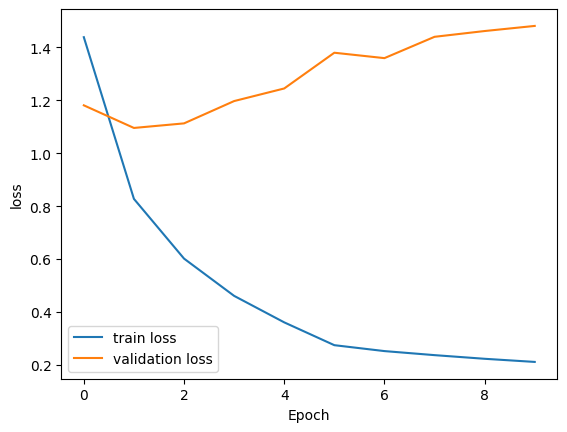

In [26]:
plt.plot(range(epoch), train_losses, label="train loss")
plt.plot(range(epoch), valid_losses, label="validation loss")
plt.ylabel("loss")
plt.xlabel('Epoch')
plt.legend()
plt.show()

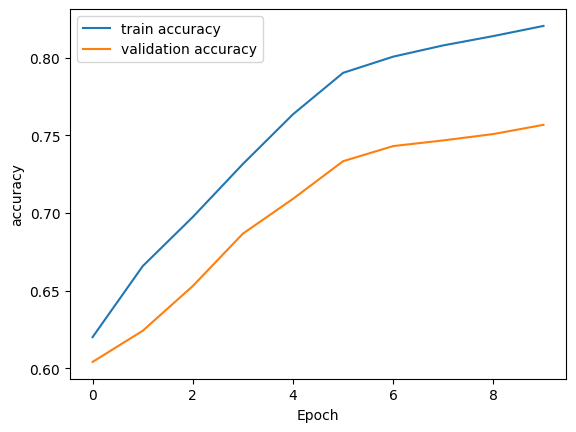

In [27]:
plt.plot(range(epoch), train_accuracy, label="train accuracy")
plt.plot(range(epoch), valid_accuracy, label="validation accuracy")
plt.ylabel("accuracy")
plt.xlabel('Epoch')
plt.legend()
plt.show()

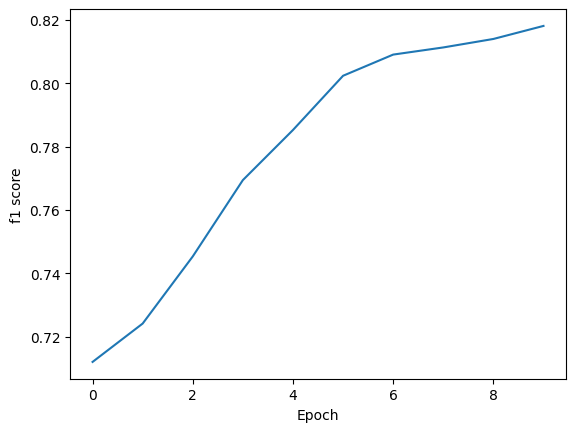

In [28]:
plt.plot(range(epoch), valid_f1, label="validation f1 score")
plt.ylabel("f1 score")
plt.xlabel('Epoch')
plt.show()

# Section 3: GRU Encoder Model

## GRU Encoder

In [ ]:
class GRU_Encoder(nn.Module):
  def __init__(self, hidden_dim, num_embeddings, embedding_dim, output_size):
    super(GRU_Encoder,self).__init__()
    self.word_embeddings = nn.Embedding(num_embeddings, embedding_dim)
    self.gru = nn.GRU(embedding_dim,hidden_dim,num_layers=1,dropout=0.1,bidirectional=False,batch_first=True)
    self.fc = nn.Linear(2*hidden_dim, output_size)



  def forward(self, text, verb_index):
    b_size = text.shape[0]
    seq_len = text.shape[1]

    embeddings = self.word_embeddings(text)
    output , _ = self.gru(embeddings)

    verb_hidden_state = output[torch.arange(b_size), verb_index, :].squeeze().reshape(b_size,1,-1)
    repeated_verb_hidden = verb_hidden_state.repeat(1, seq_len, 1)
    concat_words = torch.cat((output,repeated_verb_hidden) , dim = 2)

    out = self.fc(concat_words)

    return out

## Train Model

In [ ]:
gru_model = GRU_Encoder(hidden_dim, num_embeddings, embedding_dim, output_size)
optimizer = NAdam(gru_model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

train_losses, train_accuracy, valid_losses, valid_accuracy, valid_f1 = train(gru_model , optimizer, scheduler , loss_fn , train_loader1  , valid_loader1 , epoch , output_size , device);

  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 1 ,training loss: 1.42 , train accuracy: 0.62 

valid loss: 1.23  valid accuracy: 0.60  valid f1-score: 0.71


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 2 ,training loss: 0.83 , train accuracy: 0.66 

valid loss: 1.19  valid accuracy: 0.63  valid f1-score: 0.73


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 3 ,training loss: 0.61 , train accuracy: 0.69 

valid loss: 1.26  valid accuracy: 0.65  valid f1-score: 0.74


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 4 ,training loss: 0.47 , train accuracy: 0.72 

valid loss: 1.23  valid accuracy: 0.67  valid f1-score: 0.76


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 5 ,training loss: 0.38 , train accuracy: 0.75 

valid loss: 1.38  valid accuracy: 0.70  valid f1-score: 0.78


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 6 ,training loss: 0.29 , train accuracy: 0.78 

valid loss: 1.21  valid accuracy: 0.72  valid f1-score: 0.79


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 7 ,training loss: 0.27 , train accuracy: 0.79 

valid loss: 1.34  valid accuracy: 0.72  valid f1-score: 0.79


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 8 ,training loss: 0.25 , train accuracy: 0.80 

valid loss: 1.51  valid accuracy: 0.73  valid f1-score: 0.80


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 9 ,training loss: 0.24 , train accuracy: 0.80 

valid loss: 1.58  valid accuracy: 0.74  valid f1-score: 0.80


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 10 ,training loss: 0.22 , train accuracy: 0.81 

valid loss: 1.57  valid accuracy: 0.73  valid f1-score: 0.80


## Visualization

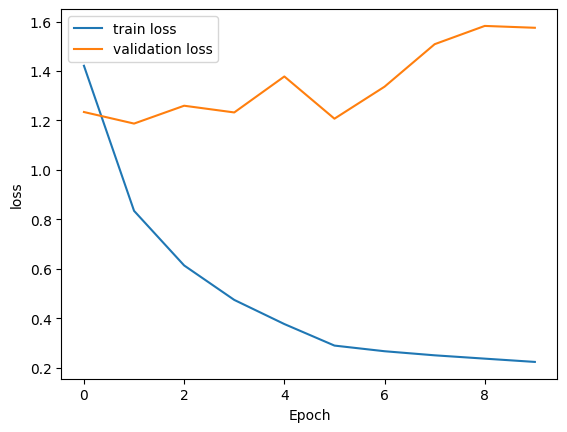

In [ ]:
plt.plot(range(epoch), train_losses, label="train loss")
plt.plot(range(epoch), valid_losses, label="validation loss")
plt.ylabel("loss")
plt.xlabel('Epoch')
plt.legend()
plt.show()

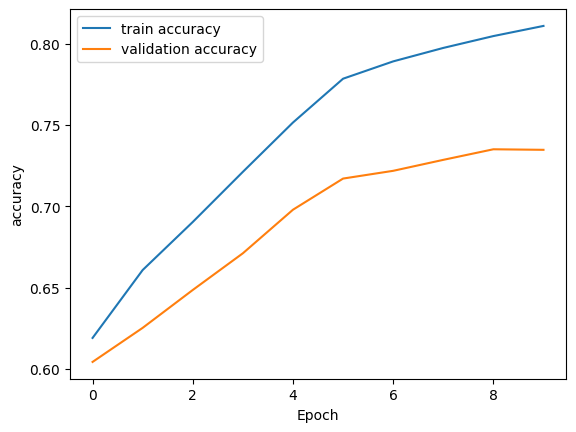

In [ ]:
plt.plot(range(epoch), train_accuracy, label="train accuracy")
plt.plot(range(epoch), valid_accuracy, label="validation accuracy")
plt.ylabel("accuracy")
plt.xlabel('Epoch')
plt.legend()
plt.show()

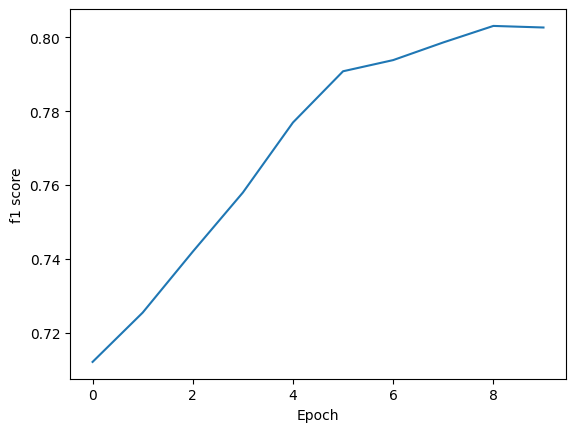

In [ ]:
plt.plot(range(epoch), valid_f1, label="validation f1 score")
plt.ylabel("f1 score")
plt.xlabel('Epoch')
plt.show()

# Section 4: Encoder-Decoder Model

## Load Glove

In [30]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

--2024-05-09 19:03:07--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

Resolving huggingface.co (huggingface.co)... 18.239.50.80, 18.239.50.103, 18.239.50.16, ...

Connecting to huggingface.co (huggingface.co)|18.239.50.80|:443... connected.

HTTP request sent, awaiting response... 302 Found

Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.6B.zip%3B+filename%3D%22glove.6B.zip%22%3B&response-content-type=application%2Fzip&Expires=1715540587&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNTU0MDU4N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9zdGFuZm9yZG5scC9nbG92ZS82NDcxMzgyY2RkODM3NTQ0YmYzYWM3MjQ5N2EzODcxNWU4NDU4OTdkMjY1YjJiNDI0YjQ3NjE4MzIwMDljODM3P3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=whOpWMMIR9P8SDHpXaq1MOKU

In [31]:
!unzip glove.6B.zip

Archive:  glove.6B.zip

  inflating: glove.6B.100d.txt       

  inflating: glove.6B.200d.txt       

  inflating: glove.6B.300d.txt       

  inflating: glove.6B.50d.txt        


In [29]:
Dim = 200
words = dict()
# filename = f'glove.6B.{Dim}d.txt'
filename = '/kaggle/input/glove-embeddings/glove.6B.200d.txt'

with open(filename, 'r') as f:
  for line in f.readlines():
    line = line.split(' ')

    try:
      words[line[0]] = np.array(line[1:], dtype=float)
    except:
      continue

## Preprocess data

In [30]:
labels = {'ARG0', 'ARG1', 'ARG2', 'ARGM-TMP', 'ARGM-LOC'}
SEP_TOKEN = '[SEPT]'

In [31]:
train_df = pd.read_json(train_path)
test_df = pd.read_json(test_path)
valid_df = pd.read_json(valid_path)

In [32]:
train_verbs=[ train_df['text'][i][train_df['verb_index'][i]] for i in range(len(train_df))]
valid_verbs=[ valid_df['text'][i][valid_df['verb_index'][i]] for i in range(len(valid_df))]

train_df['verbs'] = train_verbs
valid_df['verbs'] = valid_verbs

In [33]:
def find_full_answer(curr_txt_list, cur_srl_list, id, ilabel):
  answer = curr_txt_list[id]
  while id < len(cur_srl_list)-1:
    id+=1
    if cur_srl_list[id] == ilabel:
      answer = answer+' '+curr_txt_list[id]
    else:
      break

  return answer

In [34]:
def create_QA_df(base_df, aug=2):
    #init our lists
    list_question = []
    list_answers = []
    list_question_length = []
    list_answer_length = []

    # for each text in our base df
    for i in range(len(base_df)):
        for label in labels:
            #create question
            question = list(base_df['text'][i])
            question.insert(0, SEP_TOKEN)
            question.insert(0, base_df['verbs'][i])
            question.append(label)

            blabel = 'B-'+label
            ilabel = 'I-'+label

            #current srl frames list
            cur_srl_list = base_df['srl_frames'][i]

            #check if there is an answer or not
            if blabel in cur_srl_list:
                #save indices of blabels in a list
                indices = [i for i, x in enumerate(cur_srl_list) if x == blabel]

                for id in indices:
                    #find answer
                    answer = find_full_answer(base_df['text'][i], cur_srl_list, id, ilabel)

                    for _ in range(aug):
                        #adding new row to QA df
                        list_question.append(question)
                        list_question_length.append(len(question))

                        #add the answer
                        list_answers.append((Start_token+' '+answer+' '+End_token).split())
                        list_answer_length.append(len(answer.split())+1)
            else:

                list_question.append(question)
                list_question_length.append(len(question))
                list_answers.append([Start_token, End_token])
                list_answer_length.append(1)

    return pd.DataFrame({'question':list_question, 'answer':list_answers, 'question_len': list_question_length, 'answer_len': list_answer_length})

In [35]:
train_QA_df = create_QA_df(train_df,2)
valid_QA_df = create_QA_df(valid_df,1)

In [36]:
train_QA_df

,question,answer,question_len,answer_len
0,"[inscribed, [SEPT], A, primary, stele, ,, thre...","[<s>, </s>]",16,1
1,"[inscribed, [SEPT], A, primary, stele, ,, thre...","[<s>, </s>]",16,1
2,"[inscribed, [SEPT], A, primary, stele, ,, thre...","[<s>, </s>]",16,1
3,"[inscribed, [SEPT], A, primary, stele, ,, thre...","[<s>, steles, </s>]",16,2
4,"[inscribed, [SEPT], A, primary, stele, ,, thre...","[<s>, steles, </s>]",16,2
...,...,...,...,...
88760,"[write, [SEPT], We, also, have, to, make, it, ...","[<s>, </s>]",23,1
88761,"[write, [SEPT], We, also, have, to, make, it, ...","[<s>, </s>]",23,1
88762,"[write, [SEPT], We, also, have, to, make, it, ...","[<s>, the, data, block, </s>]",23,4
88763,"[write, [SEPT], We, also, have, to, make, it, ...","[<s>, the, data, block, </s>]",23,4


## create dataset and dataloader

In [37]:
train_vocab.add(SEP_TOKEN)
for label in labels:
  train_vocab.add(label)

In [38]:
train_QA_df['question'] = train_vocab.to_input_tensor(train_QA_df['question'])
valid_QA_df['question'] = train_vocab.to_input_tensor(valid_QA_df['question'])

train_QA_df['answer'] = train_vocab.to_input_tensor(train_QA_df['answer'])
valid_QA_df['answer'] = train_vocab.to_input_tensor(valid_QA_df['answer'])

In [39]:
n = len(train_QA_df)//2
n

44382

In [40]:
train_QA_df[:n] = train_QA_df[:n].sort_values(by=['answer_len'], ascending=False)
train_QA_df[n+1:] = train_QA_df[n+1:].sort_values(by=['answer_len'], ascending=False)

In [41]:
train_QA_df

,question,answer,question_len,answer_len
0,"[884, 8158, 121, 884, 7, 1, 1, 7953, 4, 10, 1,...","[2, 7, 1, 1, 7953, 4, 10, 1, 541, 13, 34, 4199...",49,16
1,"[4210, 8158, 170, 101, 12, 5, 874, 209, 5, 615...","[2, 29, 5, 496, 9, 7170, 1030, 20, 35, 2331, 7...",49,16
2,"[4210, 8158, 170, 101, 12, 5, 874, 209, 5, 615...","[2, 29, 5, 496, 9, 7170, 1030, 20, 35, 2331, 7...",49,16
3,"[884, 8158, 121, 884, 7, 1, 1, 7953, 4, 10, 1,...","[2, 7, 1, 1, 7953, 4, 10, 1, 541, 13, 34, 4199...",49,16
4,"[117, 8158, 19, 22, 4052, 12, 7, 117, 5, 3326,...","[2, 5, 3326, 8, 5, 504, 113, 1319, 18, 10, 381...",50,15
...,...,...,...,...
88760,"[2484, 8158, 155, 434, 5, 984, 2484, 119, 200,...","[2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17,1
88761,"[2484, 8158, 155, 434, 5, 984, 2484, 119, 200,...","[2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17,1
88762,"[2484, 8158, 155, 434, 5, 984, 2484, 119, 200,...","[2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17,1
88763,"[2484, 8158, 155, 434, 5, 984, 2484, 119, 200,...","[2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17,1


In [42]:
train_dataset = Dataset.from_pandas(train_QA_df)
valid_dataset = Dataset.from_pandas(valid_QA_df)

In [43]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, drop_last = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, drop_last=True)

## create embeddings of vocab

In [44]:
def vocab_to_word_vectors(vocab: Vocab, glove=words):
  vectors = []

  for token, id in vocab.word2id.items():
    if token not in glove:
      rand_list = [0]*Dim
      vectors.append(rand_list)
    else:
      vectors.append(glove[token])

  return np.array(vectors, dtype=float)

In [45]:
vocab_embeddings = vocab_to_word_vectors(train_vocab)

In [46]:
vocab_embeddings_npa = np.array(vocab_embeddings)

In [47]:
vocab_embeddings_npa.shape

(8164, 200)

## Implement Model

In [48]:
class Encoder(nn.Module):
    def __init__(self, padding_idx, embs_npa, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(), freeze=False, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers,dropout=p, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)

    def forward(self, x, input_lengths):
        # x: (seq_length, N) where N is batch size
        embedding = self.embedding(x)
        # embedding shape: (seq_length, N, embedding_size)

        packed = torch.nn.utils.rnn.pack_padded_sequence(embedding, input_lengths, enforce_sorted=False)

        encoder_states, (hidden, cell) = self.lstm(packed)
        # outputs shape: (seq_length, N, hidden_size)
        encoder_states, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(encoder_states)

        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell


In [49]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()
        self.energy = nn.Linear(hidden_size * 3, 1)


    def forward(self, encoder_states, decoder_hidden):
        # encoder_outputs: (batch_size, seq_len, hidden_dim)
        # decoder_hidden: (batch_size, hidden_dim)

        # Calculate the attention scores.
        energy = self.relu(self.energy(torch.cat((decoder_hidden, encoder_states), dim=2)))
        attention = self.softmax(energy)
        context_vector = torch.einsum("snk,snl->knl", attention, encoder_states)

        return context_vector

class Decoder(nn.Module):
    def __init__(
        self, padding_idx, embs_npa, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.relu = nn.ReLU()

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(), freeze=False, padding_idx=padding_idx)
        self.lstm = nn.LSTM(hidden_size * 2 + embedding_size, hidden_size, num_layers, dropout=0.2)

        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.attention = Attention()


    def forward(self, x, input_lengths, encoder_states, hidden, cell):
        x = x.unsqueeze(0)
        # x: (1, N) where N is the batch size
        embedding = self.relu(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)

        context_vector = self.attention(encoder_states, h_reshaped)

        lstm_input = torch.cat((context_vector, embedding), dim=2)
        # lstm_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        output = self.dropout(self.fc(outputs.squeeze(0)))

        return output, hidden, cell


In [50]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def batch_beam_decode(self, target_len, vocab: Vocab, source, source_len, x, encoder_states, hidden, cell, beam_width=16, p=0.6):
        decoder_output, hidden, cell = self.decoder(x,source_len, encoder_states, hidden, cell)
        #decoder output shape :(1, vocab_size)
        decoder_output = F.softmax(decoder_output)
        top_k_log, top_k_indexes = torch.topk(decoder_output, beam_width, dim=1)
        #shape of top_k_indexes :(1, beam_width)

        top_k_ans = [(Start_token+' '+vocab.id2word[word_id.item()], decoder_output[0][word_id].item()) for word_id in top_k_indexes[0]]
        complete_answers = []
        len_answ = beam_width

        t = 2
        while t < target_len and beam_width>0:
            t+=1
            curr_top = []

            #expand each branch
            for words_list, proba in top_k_ans:

                word_id = vocab.word2id[words_list.split()[-1]]
                word_id = torch.tensor([word_id]).to(self.device)
                decoder_output, hidden, cell = self.decoder(word_id, source_len, encoder_states, hidden, cell)

                #find top k
                decoder_output = F.softmax(decoder_output)
                current_k_log, current_k_indexes = torch.topk(decoder_output, beam_width, dim=1)

                curr_top += list([(words_list+ ' ' +vocab.id2word[word_id.item()],
                                   int(proba*decoder_output[0][word_id].item()))
                                    for word_id in current_k_indexes[0]])


            #select k answer with high probability
            top_k_ans = sorted(curr_top, key=lambda x: x[1], reverse=True)[:beam_width]

            removed_ans = []
            for translation, proba in top_k_ans:
                #translation is a string of words
                #add a probabiltity so the output can be other things rather than just </S> token
                if End_token in translation and len(translation.split())<=target_len and random.random() < p:
                    beam_width-=1
                    removed_ans.append((translation, proba))
                    complete_answers.append(translation.split())

            #removed the answers added to complete_answers
            for tp in removed_ans:
                top_k_ans.remove(tp)


        #add to complete_answers if it has less than beam_width element
        nn = len(complete_answers)
        if nn<len_answ:
            for translation, proba in top_k_ans[:len_answ-nn]:
                #translation is a string of words
                complete_answers.append(translation.split())

        #convert complete_answers to tensors
        output_batch = torch.tensor(vocab.to_input_tensor(complete_answers, padding=target_len)).to(self.device)

        return output_batch.T

    def beam_decode(self, vocab: Vocab, source, source_len, target, beam_width=16):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        outputs = torch.zeros(target_len, batch_size, beam_width).to(self.device)

        encoder_states, hidden, cell = self.encoder(source, source_len)

        # First input will be <S> token
        x = target[0]

        # generate answer for each batch (it is a little slow!)
        for b in range(batch_size):
            b_x = torch.tensor([x[b].item()]).to(self.device)
            outputs[:,b,:] = self.batch_beam_decode(target_len, vocab, source, source_len, b_x, encoder_states[:,b,:].unsqueeze(1), hidden[:,b].unsqueeze(1), cell[:,b].unsqueeze(1))

        return outputs

    def forward(self, vocab, source, source_len, target, target_vocab_size, teacher_force_ratio=1.0):
        batch_size = source.shape[1]
        target_len = target.shape[0]

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        encoder_states, hidden, cell = self.encoder(source, source_len)

        # First input will be <S> token
        x = target[0]

        for t in range(1, target_len):
            # At every time step use encoder_states and update hidden, cell
            output, hidden, cell = self.decoder(x, source_len, encoder_states, hidden, cell)

            # Store prediction for current time step
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs


## Train Model

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 12
learning_rate = 4e-3
output_size = train_vocab.__len__()

embedding_size = Dim
hidden_size = 256
num_layers = 1
enc_dropout = 0.2
dec_dropout = 0.8

In [52]:
encoder_net = Encoder(
    train_vocab.word2id[Pad_token],
    vocab_embeddings_npa,
    embedding_size,
    hidden_size,
    num_layers,
    enc_dropout
).to(device)

decoder_net = Decoder(
    train_vocab.word2id[Pad_token],
    vocab_embeddings_npa,
    embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

In [53]:
model = Seq2Seq(encoder_net, decoder_net, device).to(device)
optimizer = NAdam(model.parameters(), lr=learning_rate)

pad_idx = train_vocab.word2id[Pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [59]:
def seq2seq_validation(model, train_vocab, output_size, val_loader, device):
    val_loss = 0.0
    model.eval()
    reals = []
    preds_list = []
    for batch in tqdm_notebook(val_loader):
      # Get input and targets and get to cuda
        inp_data = torch.tensor(np.array(batch['question'])).to(device)
        inp_len = torch.tensor(np.array(batch['question_len']))
        target = torch.tensor(np.array(batch['answer'])).to(device)

        with torch.no_grad():
            output = model.beam_decode(train_vocab, inp_data, inp_len, target)

        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
#         print(output.shape)

        preds_list += output[:,0].cpu().numpy().tolist()

        reals += target.cpu().numpy().tolist()


    f1 =  f1_score(reals, preds_list, average='weighted')
    return f1

In [55]:
train_losses = []
train_accuracy = []
validation_f1 = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    t_preds = []
    t_target = []

    for batch in tqdm_notebook(train_loader):
        # Get input and targets and get to cuda
        inp_data = torch.tensor(np.array(batch['question'])).to(device)
        inp_len = torch.tensor(np.array(batch['question_len']))
        target = torch.tensor(np.array(batch['answer'])).to(device)


        # Forward prop
        output = model(train_vocab, inp_data, inp_len, target, output_size)

        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()

        loss = criterion(output, target)
        #output shape:((seq_len-1)*N,V)
        #target shape:((seq_len-1)*N)

        # Back prop
        loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()

        total_loss+=loss.item()
        t_preds +=  output.argmax(axis=1).cpu().numpy().tolist()
        t_target += target.cpu().numpy().tolist()


    training_loss = total_loss / len(train_loader)
    train_losses.append(training_loss)
    accuracy =  accuracy_score(t_target, t_preds, normalize=True)
    train_accuracy.append(accuracy)
    f1 =  f1_score(t_target, t_preds, average='weighted')

    print('Epoch: {} ,training loss: {:.2f} , train accuracy: {:.2f} , f1-score: {:.2f}'.format(epoch+1 , training_loss ,accuracy, f1))

  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 1 ,training loss: 7.52 , train accuracy: 0.36 , f1-score: 0.50


  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 2 ,training loss: 7.52 , train accuracy: 0.44 , f1-score: 0.57


  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 3 ,training loss: 7.54 , train accuracy: 0.47 , f1-score: 0.60


  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 4 ,training loss: 7.53 , train accuracy: 0.50 , f1-score: 0.62


  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 5 ,training loss: 7.53 , train accuracy: 0.44 , f1-score: 0.57


  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 6 ,training loss: 7.56 , train accuracy: 0.45 , f1-score: 0.58


  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 7 ,training loss: 7.56 , train accuracy: 0.46 , f1-score: 0.59


  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 8 ,training loss: 7.59 , train accuracy: 0.44 , f1-score: 0.57


  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 9 ,training loss: 7.58 , train accuracy: 0.49 , f1-score: 0.62


  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 10 ,training loss: 7.58 , train accuracy: 0.40 , f1-score: 0.54


  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 11 ,training loss: 7.56 , train accuracy: 0.40 , f1-score: 0.53


  0%|          | 0/1386 [00:00<?, ?it/s]

Epoch: 12 ,training loss: 7.54 , train accuracy: 0.47 , f1-score: 0.60


In [60]:
val_f1 = seq2seq_validation(model, train_vocab, output_size, valid_loader, device)
print('validation f1-score: {:.2f} '.format(val_f1))

  0%|          | 0/62 [00:00<?, ?it/s]

validation f1-score: 0.89 


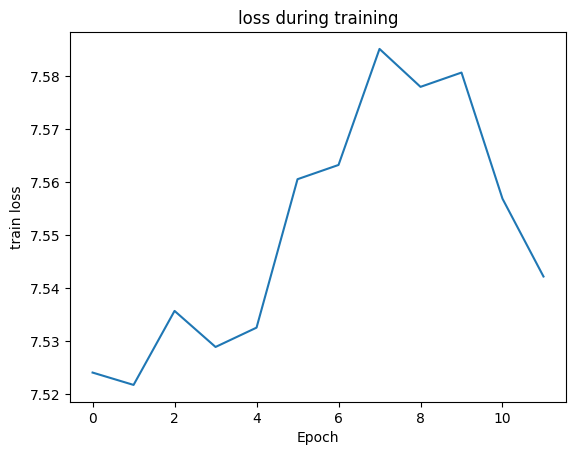

In [61]:
plt.plot(range(num_epochs), train_losses)
plt.ylabel("train loss")
plt.xlabel('Epoch')
plt.title('loss during training')
plt.show()

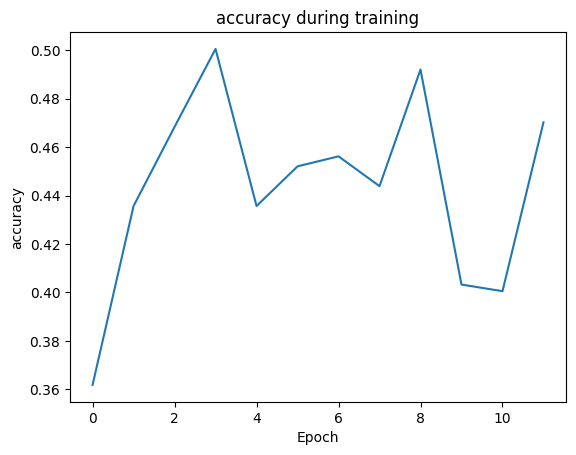

In [62]:
plt.plot(range(num_epochs), train_accuracy)
plt.ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('accuracy during training')
plt.show()

# Section 5.1

In [63]:
labels = list(labels)
labels

['ARG0', 'ARG2', 'ARGM-LOC', 'ARG1', 'ARGM-TMP']

In [64]:
valid_df.head()

,text,srl_frames,verb_index,words_indices,verbs
0,"[In, the, summer, of, 2005, ,, a, picture, tha...","[O, O, O, O, O, O, O, O, O, B-ARG0, O, B-ARGM-...",13,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",looking
1,"[The, most, important, thing, about, Disney, i...","[O, O, O, O, O, O, O, O, B-ARG1, O, B-ARG2, I-...",9,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3...",is
2,"[Well, ,, for, several, years, ,, although, it...","[O, O, O, O, O, O, O, B-ARG1, O, B-ARGM-TMP, B...",8,"[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5...",was
3,"[However, ,, before, any, of, the, Disney, sym...","[O, O, O, B-ARG1, I-ARG1, I-ARG1, I-ARG1, I-AR...",8,"[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8...",were
4,"[Er, ,, according, to, what, the, security, gu...","[O, O, O, O, B-ARG1, B-ARG0, I-ARG0, I-ARG0, O...",8,"[105, 106, 107, 108, 109, 110, 111, 112, 113, ...",said


In [65]:
def create_label_df(base_df, label):
    #init our lists
    list_text = []
    list_srl = []
    list_verbs = []
    list_verb_index = []

    blabel = 'B-'+label
    # for each text in our base df
    for i in range(len(base_df)):
        if blabel in base_df['srl_frames'][i]:

            list_text.append(base_df['text'][i])
            list_srl.append(base_df['srl_frames'][i])
            list_verbs.append(base_df['verbs'][i])
            list_verb_index.append(base_df['verb_index'][i])



    return pd.DataFrame({'text':list_text, 'srl_frames':list_srl, 'verb_index': list_verb_index, 'verbs': list_verbs})

In [66]:
batch_size = 64
num_classes = 9

## label0: ARGM-LOC

### LSTM model

In [86]:
df0 = create_label_df(valid_df, labels[0])
Max_len = max([len(x) for x in df0['text']])

In [87]:
# add padding to srl frames
valid_padded_srl_frames = add_padding(df0['srl_frames'], Max_len, 'O')

# covert srl frames to number
df0['srl_frames'] = srl_frames_to_number(valid_padded_srl_frames)


# replace text by their corresponding ids
df0['text'] = train_vocab.to_input_tensor(df0['text'])

valid_dataset = Dataset.from_pandas(df0)

valid_loader_l0 = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,shuffle=True )

In [88]:
_ = validation(model_lstm , valid_loader_l0 , loss_fn ,num_classes, device  )

valid loss: 1.49  valid accuracy: 0.75  valid f1-score: 0.81


### encoder-decoder

In [ ]:
df0 = create_label_df(valid_df, labels[0])
valid_QA_df = create_QA_df(df0,1)

valid_QA_df['question'] = train_vocab.to_input_tensor(valid_QA_df['question'])

valid_QA_df['answer'] = train_vocab.to_input_tensor(valid_QA_df['answer'])

valid_dataset = Dataset.from_pandas(valid_QA_df)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
val_f1 = seq2seq_validation(model, train_vocab, output_size, valid_loader, device)
print('validation f1-score: {:.2f} '.format(val_f1))

  0%|          | 0/1 [00:00<?, ?it/s]

validation f1-score: 0.70 


## label1: ARG2

### LSTM model

In [ ]:
df1 = create_label_df(valid_df, labels[1])
Max_len = max([len(x) for x in df1['text']])

In [ ]:
# add padding to srl frames
valid_padded_srl_frames = add_padding(df1['srl_frames'], Max_len, 'O')

# covert srl frames to number
df1['srl_frames'] = srl_frames_to_number(valid_padded_srl_frames)


# replace text by their corresponding ids
df1['text'] = train_vocab.to_input_tensor(df1['text'])

valid_dataset = Dataset.from_pandas(df1)

valid_loader_l1 = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,shuffle=True )

In [ ]:
_ = validation(model_lstm , valid_loader_l1 , loss_fn ,num_classes, device  )

valid loss: 1.47  valid accuracy: 0.74  valid f1-score: 0.80


### encoder-decoder

In [ ]:
df1 = create_label_df(valid_df, labels[1])
valid_QA_df = create_QA_df(df1,1)

valid_QA_df['question'] = train_vocab.to_input_tensor(valid_QA_df['question'])

valid_QA_df['answer'] = train_vocab.to_input_tensor(valid_QA_df['answer'])

valid_dataset = Dataset.from_pandas(valid_QA_df)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
val_f1 = seq2seq_validation(model, train_vocab, output_size, valid_loader, device)
print('validation f1-score: {:.2f} '.format(val_f1))

  0%|          | 0/18 [00:00<?, ?it/s]

validation f1-score: 0.86 


## label2: ARGM-TMP

### LSTM model

In [ ]:
df2 = create_label_df(valid_df, labels[2])
Max_len = max([len(x) for x in df2['text']])

In [ ]:
# add padding to srl frames
valid_padded_srl_frames = add_padding(df2['srl_frames'], Max_len, 'O')

# covert srl frames to number
df2['srl_frames'] = srl_frames_to_number(valid_padded_srl_frames)


# replace text by their corresponding ids
df2['text'] = train_vocab.to_input_tensor(df2['text'])

valid_dataset = Dataset.from_pandas(df2)

valid_loader_l2 = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,shuffle=True )

In [ ]:
_ = validation(model_lstm , valid_loader_l2 , loss_fn ,num_classes, device  )

valid loss: 0.88  valid accuracy: 0.75  valid f1-score: 0.81


### encoder-decoder

In [ ]:
df2 = create_label_df(valid_df, labels[2])
valid_QA_df = create_QA_df(df2,1)

valid_QA_df['question'] = train_vocab.to_input_tensor(valid_QA_df['question'])

valid_QA_df['answer'] = train_vocab.to_input_tensor(valid_QA_df['answer'])

valid_dataset = Dataset.from_pandas(valid_QA_df)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
val_f1 = seq2seq_validation(model, train_vocab, output_size, valid_loader, device)
print('validation f1-score: {:.2f} '.format(val_f1))

  0%|          | 0/6 [00:00<?, ?it/s]

validation f1-score: 0.81 


## label3: ARG0

### LSTM model

In [ ]:
df3 = create_label_df(valid_df, labels[3])
Max_len = max([len(x) for x in df3['text']])

In [ ]:
# add padding to srl frames
valid_padded_srl_frames = add_padding(df3['srl_frames'], Max_len, 'O')

# covert srl frames to number
df3['srl_frames'] = srl_frames_to_number(valid_padded_srl_frames)


# replace text by their corresponding ids
df3['text'] = train_vocab.to_input_tensor(df3['text'])

valid_dataset = Dataset.from_pandas(df3)

valid_loader_l3 = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,shuffle=True )

In [ ]:
_ = validation(model_lstm , valid_loader_l3 , loss_fn ,num_classes, device  )

valid loss: 1.42  valid accuracy: 0.76  valid f1-score: 0.82


### encoder-decoder

In [ ]:
df3 = create_label_df(valid_df, labels[3])
valid_QA_df = create_QA_df(df3,1)

valid_QA_df['question'] = train_vocab.to_input_tensor(valid_QA_df['question'])

valid_QA_df['answer'] = train_vocab.to_input_tensor(valid_QA_df['answer'])

valid_dataset = Dataset.from_pandas(valid_QA_df)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
val_f1 = seq2seq_validation(model, train_vocab, output_size, valid_loader, device)
print('validation f1-score: {:.2f} '.format(val_f1))

  0%|          | 0/28 [00:00<?, ?it/s]

validation f1-score: 0.86 


## label4: ARG1

### LSTM model

In [ ]:
df4 = create_label_df(valid_df, labels[4])
Max_len = max([len(x) for x in df4['text']])

In [ ]:
# add padding to srl frames
valid_padded_srl_frames = add_padding(df4['srl_frames'], Max_len, 'O')

# covert srl frames to number
df4['srl_frames'] = srl_frames_to_number(valid_padded_srl_frames)


# replace text by their corresponding ids
df4['text'] = train_vocab.to_input_tensor(df4['text'])

valid_dataset = Dataset.from_pandas(df4)

valid_loader_l4 = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,shuffle=True )

In [ ]:
_ = validation(model_lstm , valid_loader_l4 , loss_fn ,num_classes, device  )

valid loss: 1.40  valid accuracy: 0.75  valid f1-score: 0.81


### encoder-decoder

In [ ]:
df4 = create_label_df(valid_df, labels[4])
valid_QA_df = create_QA_df(df4,1)

valid_QA_df['question'] = train_vocab.to_input_tensor(valid_QA_df['question'])

valid_QA_df['answer'] = train_vocab.to_input_tensor(valid_QA_df['answer'])

valid_dataset = Dataset.from_pandas(valid_QA_df)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
val_f1 = seq2seq_validation(model, train_vocab, output_size, valid_loader, device)
print('validation f1-score: {:.2f} '.format(val_f1))

  0%|          | 0/52 [00:00<?, ?it/s]

validation f1-score: 0.86 


# Section 5.2

### LSTM model

In [67]:
df0 = create_label_df(valid_df, labels[0])
df0=pd.DataFrame(df0.iloc[[4, 5],:]).reset_index()
Max_len = max(len(df0['text'][0]), len(df0['text'][1]))
df0

,index,text,srl_frames,verb_index,verbs
0,4,"[Because, ,, as, everyone, knows, ,, our, Disn...","[O, O, O, B-ARG0, O, O, O, O, O, O, O, O, O, O...",4,knows
1,5,"[They, add, to, what, we, already, have, ,, li...","[O, O, O, B-ARG1, B-ARG0, B-ARGM-TMP, O, O, O,...",6,have


In [68]:
# covert srl frames to number
valid_padded_srl_frames = add_padding(df0['srl_frames'], Max_len, 'O')
srl_frames = srl_frames_to_number(valid_padded_srl_frames)

# replace text by their corresponding ids
text = train_vocab.to_input_tensor(df0['text'])
text = torch.tensor(np.array(text)).to(device)
verb_index = torch.tensor(np.array(df0["verb_index"])).to(device)

In [69]:
verb_index

tensor([4, 6], device='cuda:0')

In [70]:
text.shape

torch.Size([2, 20])

In [71]:
with torch.no_grad():
    preds = model_lstm(text, verb_index).view(-1, num_classes)

In [72]:
preds = preds.argmax(axis=1).cpu().numpy()
preds

array([1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,
       3, 3, 1, 8, 8, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [73]:
np.array(srl_frames).reshape(-1)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 1, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [74]:
accuracy_score(np.array(srl_frames).reshape(-1), preds)

0.825

### encoder-decoder

In [80]:
df0 = create_label_df(valid_df, labels[0])
df0=pd.DataFrame(df0.iloc[[4, 5],:]).reset_index()
valid_QA_df = create_QA_df(df0,1)

valid_QA_df['question'] = train_vocab.to_input_tensor(valid_QA_df['question'])
valid_QA_df['answer'] = train_vocab.to_input_tensor(valid_QA_df['answer'])


In [81]:
valid_dataset = Dataset.from_pandas(valid_QA_df)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [82]:
for batch in valid_loader:
    inp_data = torch.tensor(np.array(batch['question'])).to(device)
    inp_len = torch.tensor(np.array(batch['question_len']))
    target = torch.tensor(np.array(batch['answer'])).to(device)

    with torch.no_grad():
        output = model.beam_decode(train_vocab, inp_data, inp_len, target)

In [87]:
output[:, :,0].T

tensor([[  2.,   3.,   3.],
        [  2.,   3., 307.],
        [  2.,   3.,   3.],
        [  2.,   3.,   3.],
        [  2.,   3.,   3.],
        [  2.,   3.,   3.],
        [  2.,   3., 168.],
        [  2.,   3., 168.],
        [  2.,   3., 168.],
        [  2.,   3.,   3.]], device='cuda:0')

In [84]:
valid_QA_df['answer']

0    [2, 445, 3]
1      [2, 3, 0]
2      [2, 3, 0]
3      [2, 3, 0]
4      [2, 3, 0]
5     [2, 39, 3]
6      [2, 3, 0]
7      [2, 3, 0]
8     [2, 41, 3]
9    [2, 228, 3]
Name: answer, dtype: object

In [92]:
accuracy_score(np.array(list(valid_QA_df['answer'])).reshape(-1), output[:, :,0].cpu().numpy().reshape(-1))

0.3333333333333333